In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from pyramid.arima import auto_arima

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')


/Users/matt_dynasty/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/matt_dynasty/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

In [3]:
df_eth = pd.read_json('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1438992000&end=9999999999&period=300')
df_eth.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,1.75,2015-08-08 06:15:00,1.75,1.61,1.65,45.000000,75.150000,1.67
1,1.85,2015-08-08 06:20:00,1.85,1.85,1.85,7.880354,14.578655,1.85
2,1.85,2015-08-08 06:25:00,1.85,1.85,1.85,0.160000,0.296000,1.85
3,1.85,2015-08-08 06:30:00,1.85,1.85,1.85,0.089794,0.166119,1.85
4,1.85,2015-08-08 06:35:00,1.85,1.85,1.85,0.000000,0.000000,1.85


In [4]:
# Taking after 2017 data.
df_eth = df_eth[150000:]
df_eth.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
150000,10.423660,2017-01-10 02:15:00,10.423660,10.423660,10.423660,0.120000,1.250839,10.423660
150001,10.423660,2017-01-10 02:20:00,10.423660,10.423660,10.423660,0.000000,0.000000,10.423660
150002,10.423660,2017-01-10 02:25:00,10.423660,10.423660,10.423660,0.000000,0.000000,10.423660
150003,10.422351,2017-01-10 02:30:00,10.422455,10.422351,10.422455,18.121348,188.867070,10.422352
150004,10.500000,2017-01-10 02:35:00,10.500000,10.500000,10.500000,0.420921,4.419670,10.500000


In [5]:
df_eth.set_index('date', inplace=True)
df_eth.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-01-10 02:15:00,10.423660,10.423660,10.423660,10.423660,0.120000,1.250839,10.423660
2017-01-10 02:20:00,10.423660,10.423660,10.423660,10.423660,0.000000,0.000000,10.423660
2017-01-10 02:25:00,10.423660,10.423660,10.423660,10.423660,0.000000,0.000000,10.423660
2017-01-10 02:30:00,10.422351,10.422455,10.422351,10.422455,18.121348,188.867070,10.422352
2017-01-10 02:35:00,10.500000,10.500000,10.500000,10.500000,0.420921,4.419670,10.500000


In [6]:
df_eth_close = df_eth[['close']]
df_eth_close.head()

,close
date,
2017-01-10 02:15:00,10.423660
2017-01-10 02:20:00,10.423660
2017-01-10 02:25:00,10.423660
2017-01-10 02:30:00,10.422351
2017-01-10 02:35:00,10.500000


In [7]:
df_eth_close.index

DatetimeIndex(['2017-01-10 02:15:00', '2017-01-10 02:20:00',
               '2017-01-10 02:25:00', '2017-01-10 02:30:00',
               '2017-01-10 02:35:00', '2017-01-10 02:40:00',
               '2017-01-10 02:45:00', '2017-01-10 02:50:00',
               '2017-01-10 02:55:00', '2017-01-10 03:00:00',
               ...
               '2018-08-15 01:15:00', '2018-08-15 01:20:00',
               '2018-08-15 01:25:00', '2018-08-15 01:30:00',
               '2018-08-15 01:35:00', '2018-08-15 01:40:00',
               '2018-08-15 01:45:00', '2018-08-15 01:50:00',
               '2018-08-15 01:55:00', '2018-08-15 02:00:00'],
              dtype='datetime64[ns]', name=u'date', length=167614, freq=None)

In [8]:
df_eth_close.shape

(167614, 1)

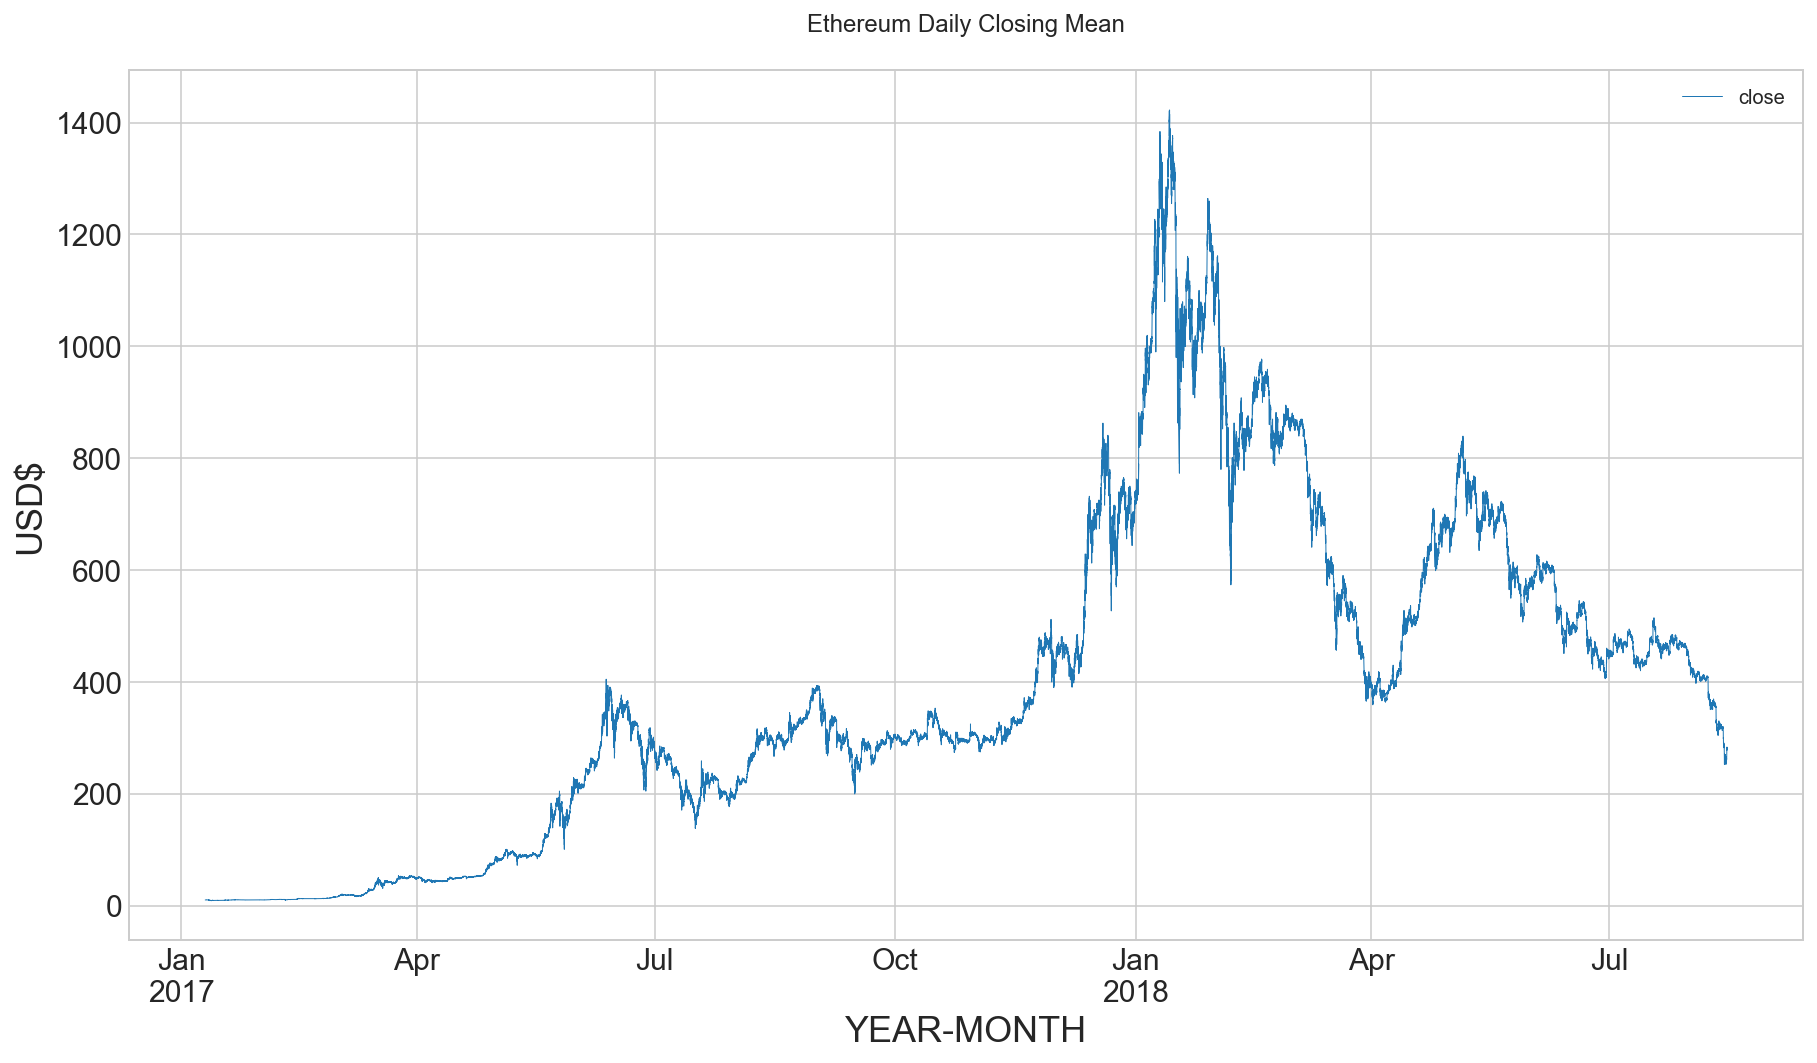

In [9]:
df_eth_close.plot(kind='line', lw='0.5', figsize=(15,8), title= 'Ethereum Daily Closing Mean\n',  fontsize=15)
plt.ylabel('USD$', fontsize=18)
plt.xlabel('YEAR-MONTH', fontsize=18)
plt.show()

In [10]:
data = df_eth_close.values

In [11]:
len(data)

167614

In [12]:
# Train 80% , Test 20%
split_point = int(len(data)*0.8)

In [13]:
# slice the data
train = data[:split_point]
test = data[split_point:]

In [14]:
# prepare the data
lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     # due to naming convention

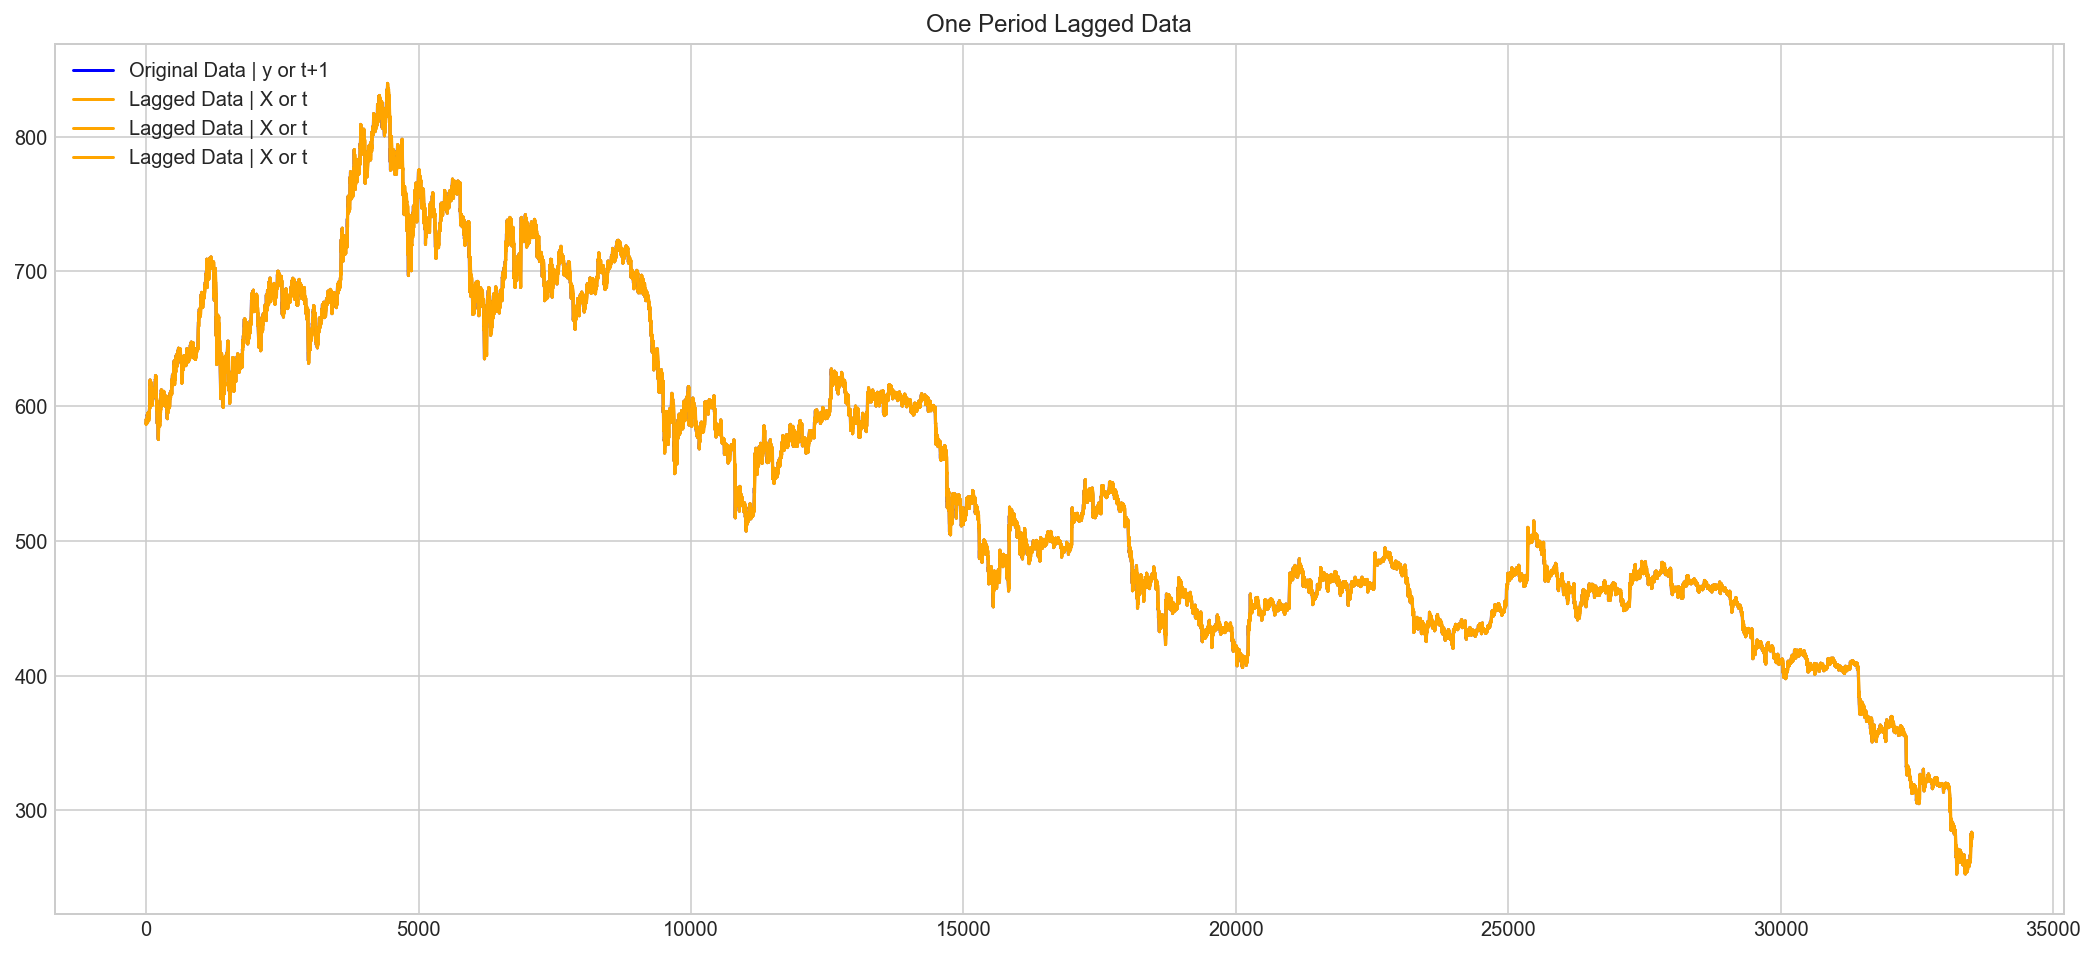

In [36]:
# plot the created data
plt.figure(figsize=(18, 8))
plt.plot(y_test, label='Original Data | y or t+1', color='blue')
plt.plot(X_test, label='Lagged Data | X or t', color='orange')
plt.legend(loc='upper left')
plt.title('One Period Lagged Data')
plt.show()

This simple network will have one input (size of the lags variable), one hidden layer with 3 neurons and an output layer. The model is fitted using the MSE criterion and rectified linear units (RELU) as activation function. We instantiate the Sequantial class, successively add the layer containing the neurons and specify the specific type of activation function within the Dense class (which correspond to the neuron. Then we specify a loss function and an optimizer to be used to adjust the networks neuron weights iteratively. Lastly, the model is fitted to the training data set.

#### Create and fit Multilayer Perceptron model

I am trying with epochs=5 just for quick run through of the process. We can increase the number of epochs for more accuracy if our computer supports it. 

In [22]:
mdl = Sequential()
mdl.add(Dense(3, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=20, batch_size=2, verbose=2)

Epoch 1/20
 - 78s - loss: 142.4145
Epoch 2/20
 - 79s - loss: 13.4781
Epoch 3/20
 - 79s - loss: 12.8427
Epoch 4/20
 - 77s - loss: 12.3156
Epoch 5/20
 - 78s - loss: 12.3155
Epoch 6/20
 - 78s - loss: 11.8331
Epoch 7/20
 - 78s - loss: 12.0127
Epoch 8/20
 - 77s - loss: 11.6051
Epoch 9/20
 - 79s - loss: 11.7399
Epoch 10/20
 - 78s - loss: 11.3564
Epoch 11/20
 - 79s - loss: 11.2871
Epoch 12/20
 - 78s - loss: 11.2541
Epoch 13/20
 - 78s - loss: 11.1584
Epoch 14/20
 - 79s - loss: 10.9995
Epoch 15/20
 - 78s - loss: 10.7682
Epoch 16/20
 - 79s - loss: 10.6999
Epoch 17/20
 - 78s - loss: 10.5025
Epoch 18/20
 - 77s - loss: 10.0620
Epoch 19/20
 - 79s - loss: 9.8710
Epoch 20/20
 - 77s - loss: 9.9013


We check for the training and test accuracy of the sample using the evaluate method. Then we call the prediction method on our model and prepare the data for plotting

In [23]:
import math
# estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 9.31 MSE (3.05 RMSE)
Test Score: 6.34 MSE (2.52 RMSE)


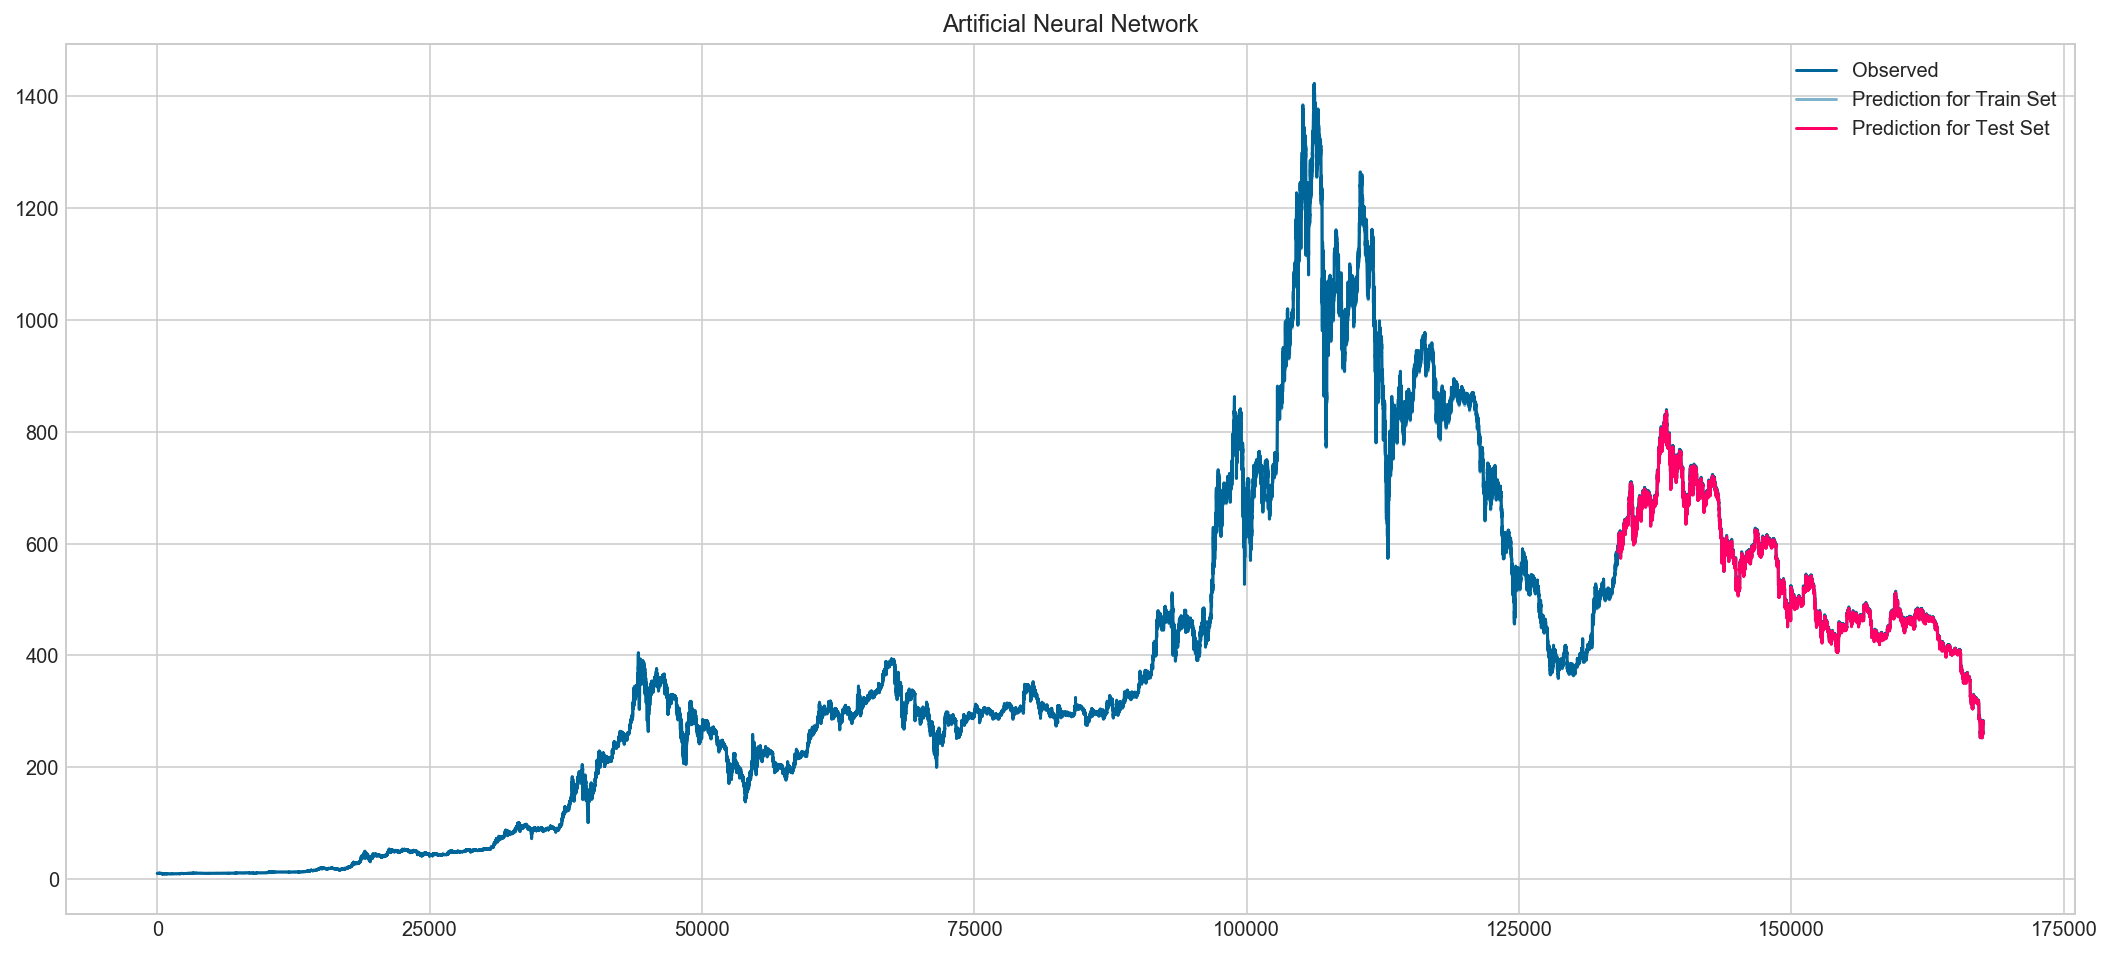

In [25]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
 
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(data)-1, :] = test_predict
 
# plot baseline and predictions
plt.figure(figsize=(18, 8))
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='best');
plt.title('Artificial Neural Network')
plt.show()

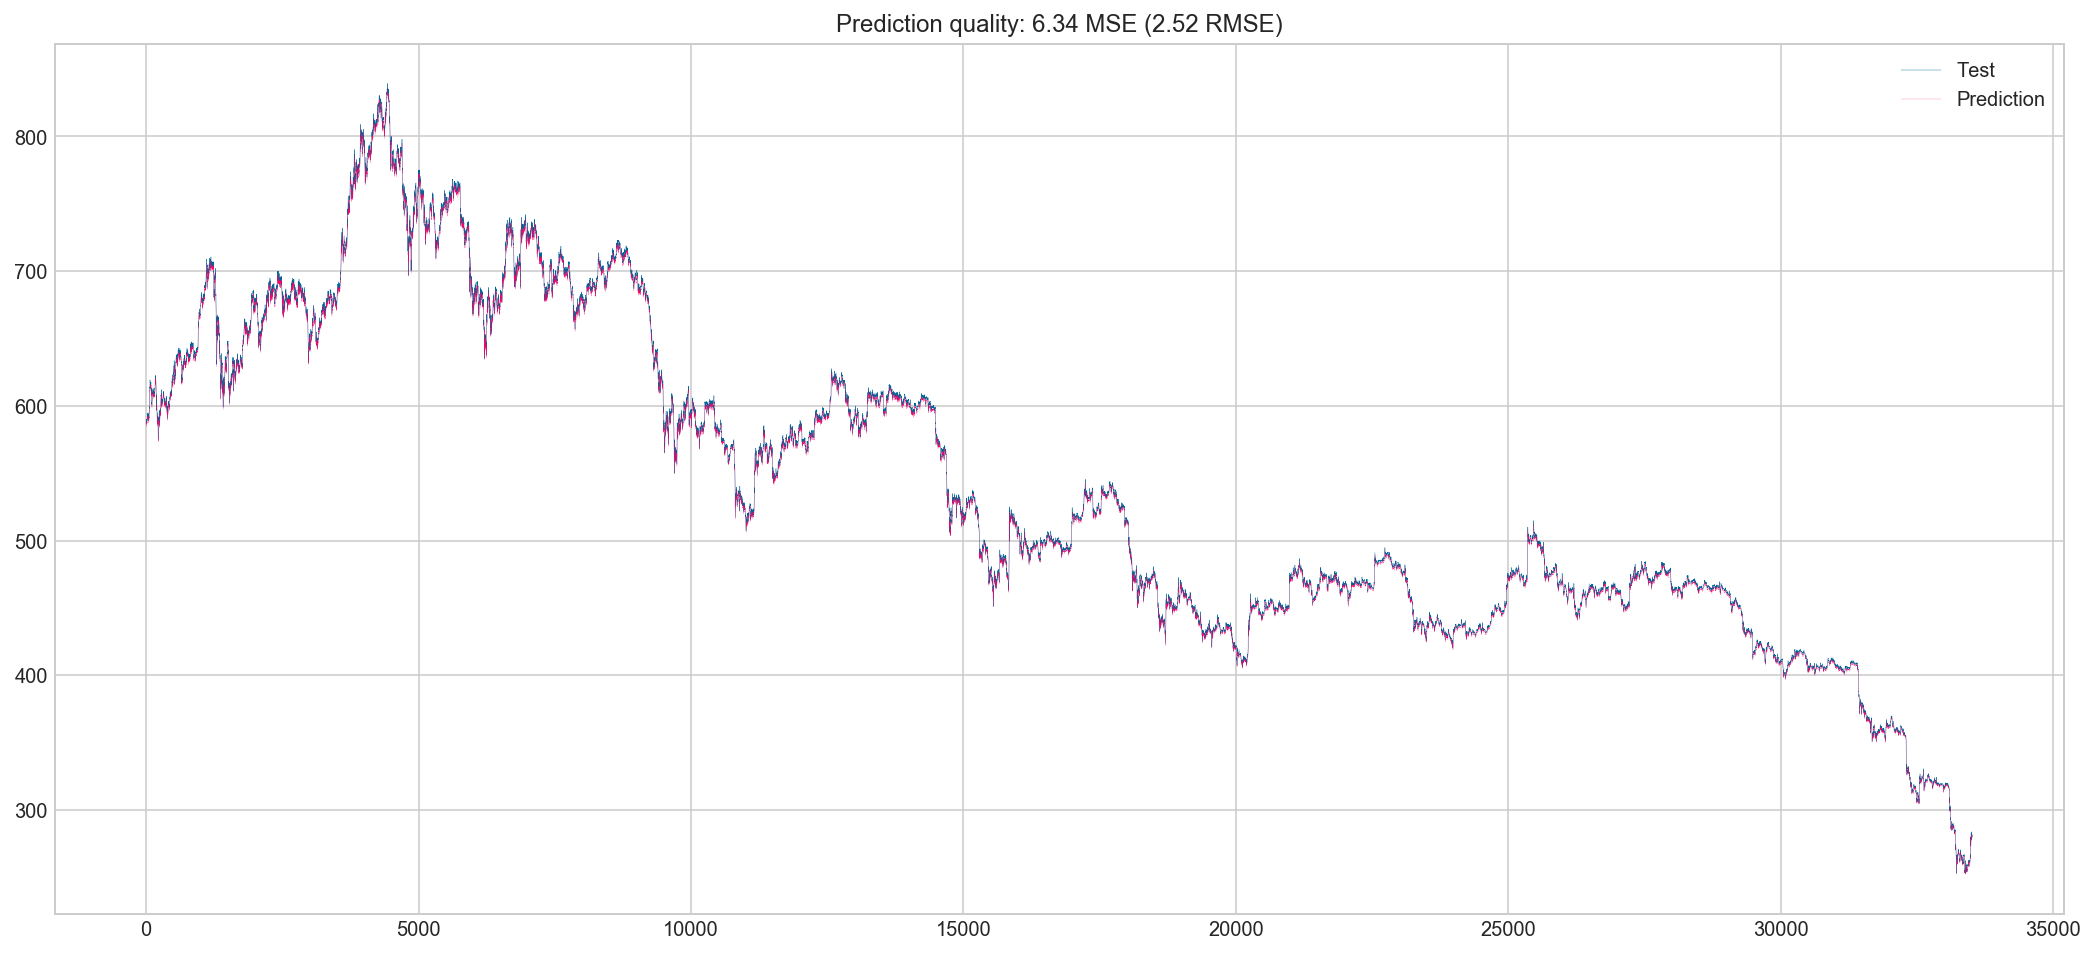

In [29]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.figure(figsize=(18, 8))
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Test', color='#006699', lw='0.2')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066', lw='0.1')
plt.legend(loc='best');
plt.show()

Since the neural network has only been fed by the last observation, it did not have much choice but to learn to apply observation t for the prediction of t+1. Next we try the MLPN with a window.

#### Multilayer Perceptron with Window

1. We improve prediction by increasing the back-looking windows(lags). 
2. Increase the number of hidden layers as well as the number of neurons for each layer.

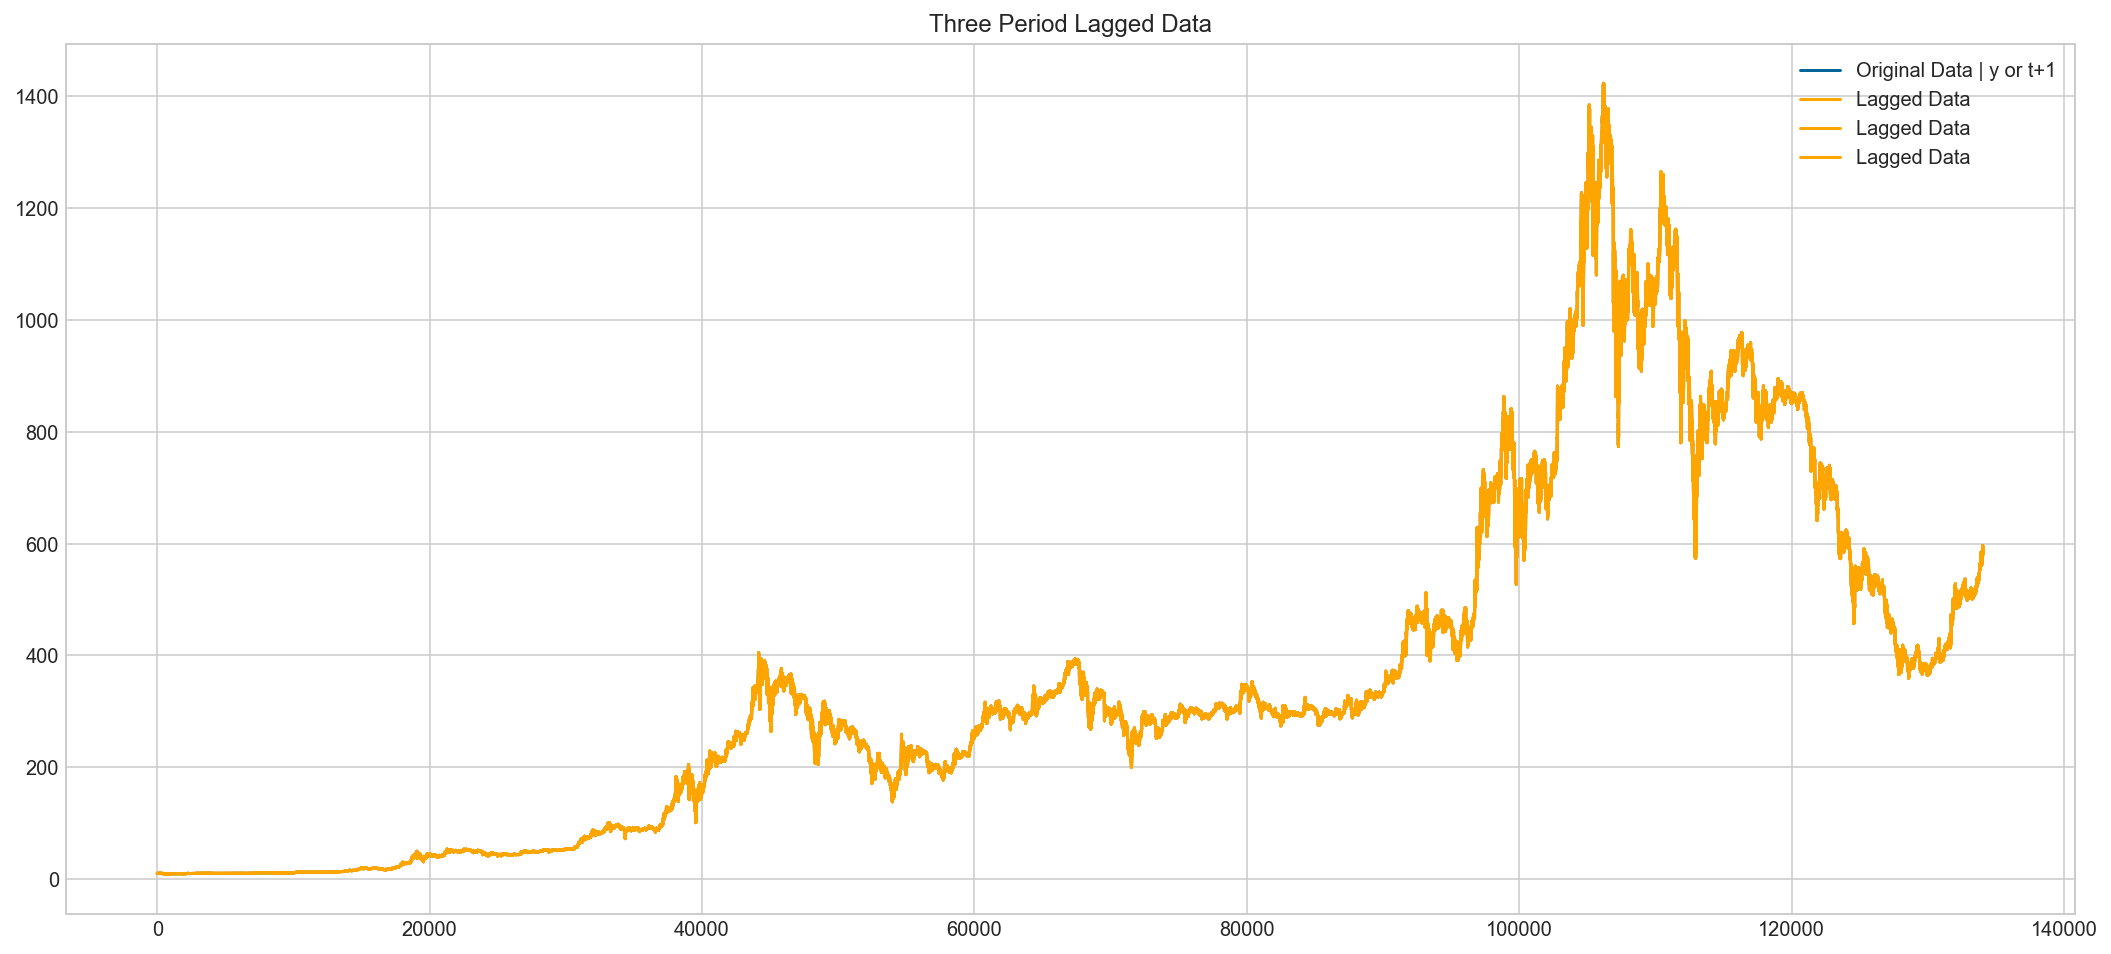

In [40]:
# reshape and lag shift the dataset
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
 
# plot the created data
plt.figure(figsize=(18, 8))
plt.plot(y_train, label='Original Data | y or t+1', color='#006699')
plt.plot(X_train, label='Lagged Data', color='orange')
plt.legend(loc='best')
plt.title('Three Period Lagged Data')
plt.show()

This network has two hidden layers with four and eight neural units. 

In [41]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(4, input_dim=lags, activation='relu'))
mdl.add(Dense(8, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=20, batch_size=2, verbose=2)
 
# Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Epoch 1/20
 - 88s - loss: 189.6711
Epoch 2/20
 - 87s - loss: 14.1090
Epoch 3/20
 - 87s - loss: 12.9088
Epoch 4/20
 - 87s - loss: 12.5857
Epoch 5/20
 - 87s - loss: 12.4058
Epoch 6/20
 - 87s - loss: 12.2894
Epoch 7/20
 - 87s - loss: 12.2082
Epoch 8/20
 - 87s - loss: 11.9289
Epoch 9/20
 - 87s - loss: 12.0078
Epoch 10/20
 - 87s - loss: 11.8661
Epoch 11/20
 - 87s - loss: 11.6341
Epoch 12/20
 - 87s - loss: 11.7355
Epoch 13/20
 - 87s - loss: 11.6190
Epoch 14/20
 - 87s - loss: 11.6392
Epoch 15/20
 - 87s - loss: 11.5577
Epoch 16/20
 - 87s - loss: 11.3852
Epoch 17/20
 - 87s - loss: 11.2888
Epoch 18/20
 - 87s - loss: 10.9407
Epoch 19/20
 - 87s - loss: 11.0932
Epoch 20/20
 - 87s - loss: 10.9823
Train Score: 17.76 MSE (4.21 RMSE)
Test Score: 17.53 MSE (4.19 RMSE)


The accuracy for our test set has improved slighthly/significantly compared to the first neural network we implemented. 
This is on account of the network utilizing a longer period of back-looking data to conduct its prediction.

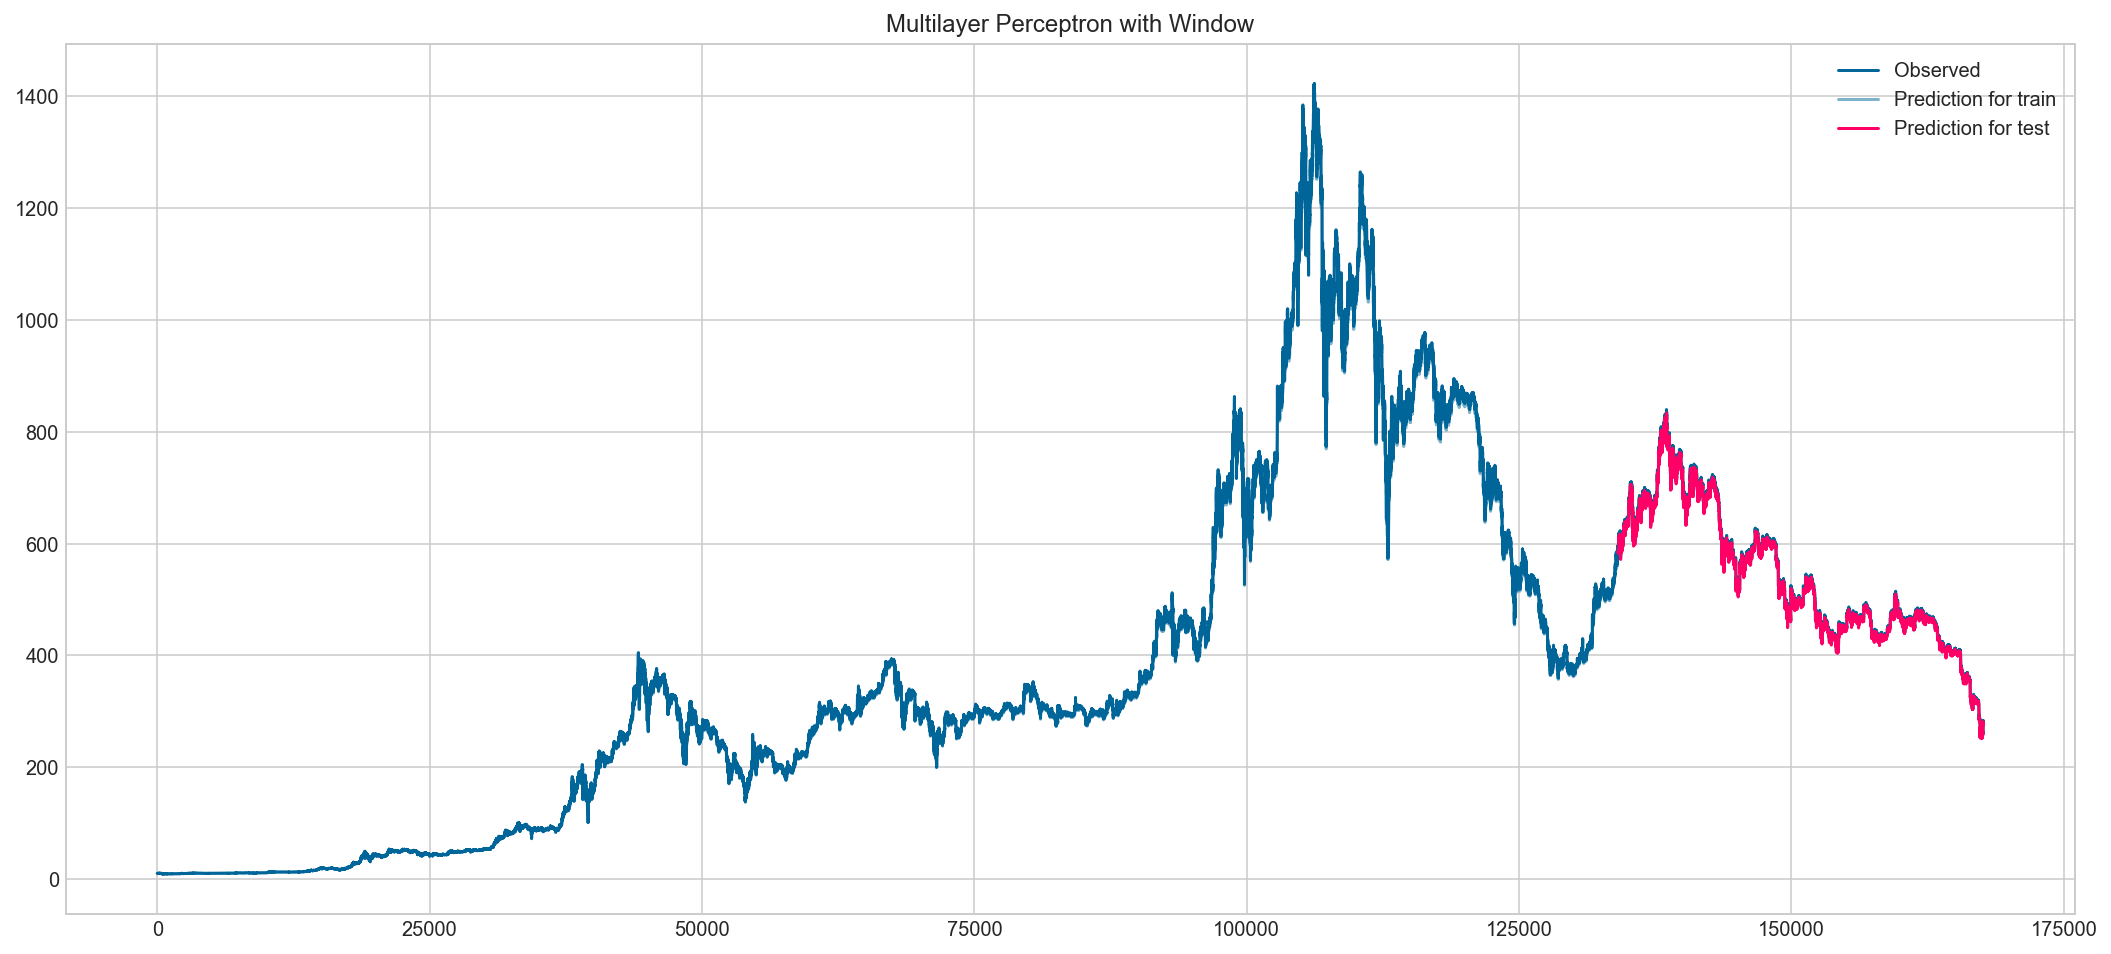

In [42]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
 
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags * 2)+1:len(data)-1, :] = test_predict
 
# plot observation and predictions
plt.figure(figsize=(18, 8))
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for train', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for test', color='#ff0066');
plt.legend(loc='best')
plt.title('Multilayer Perceptron with Window')
plt.show()

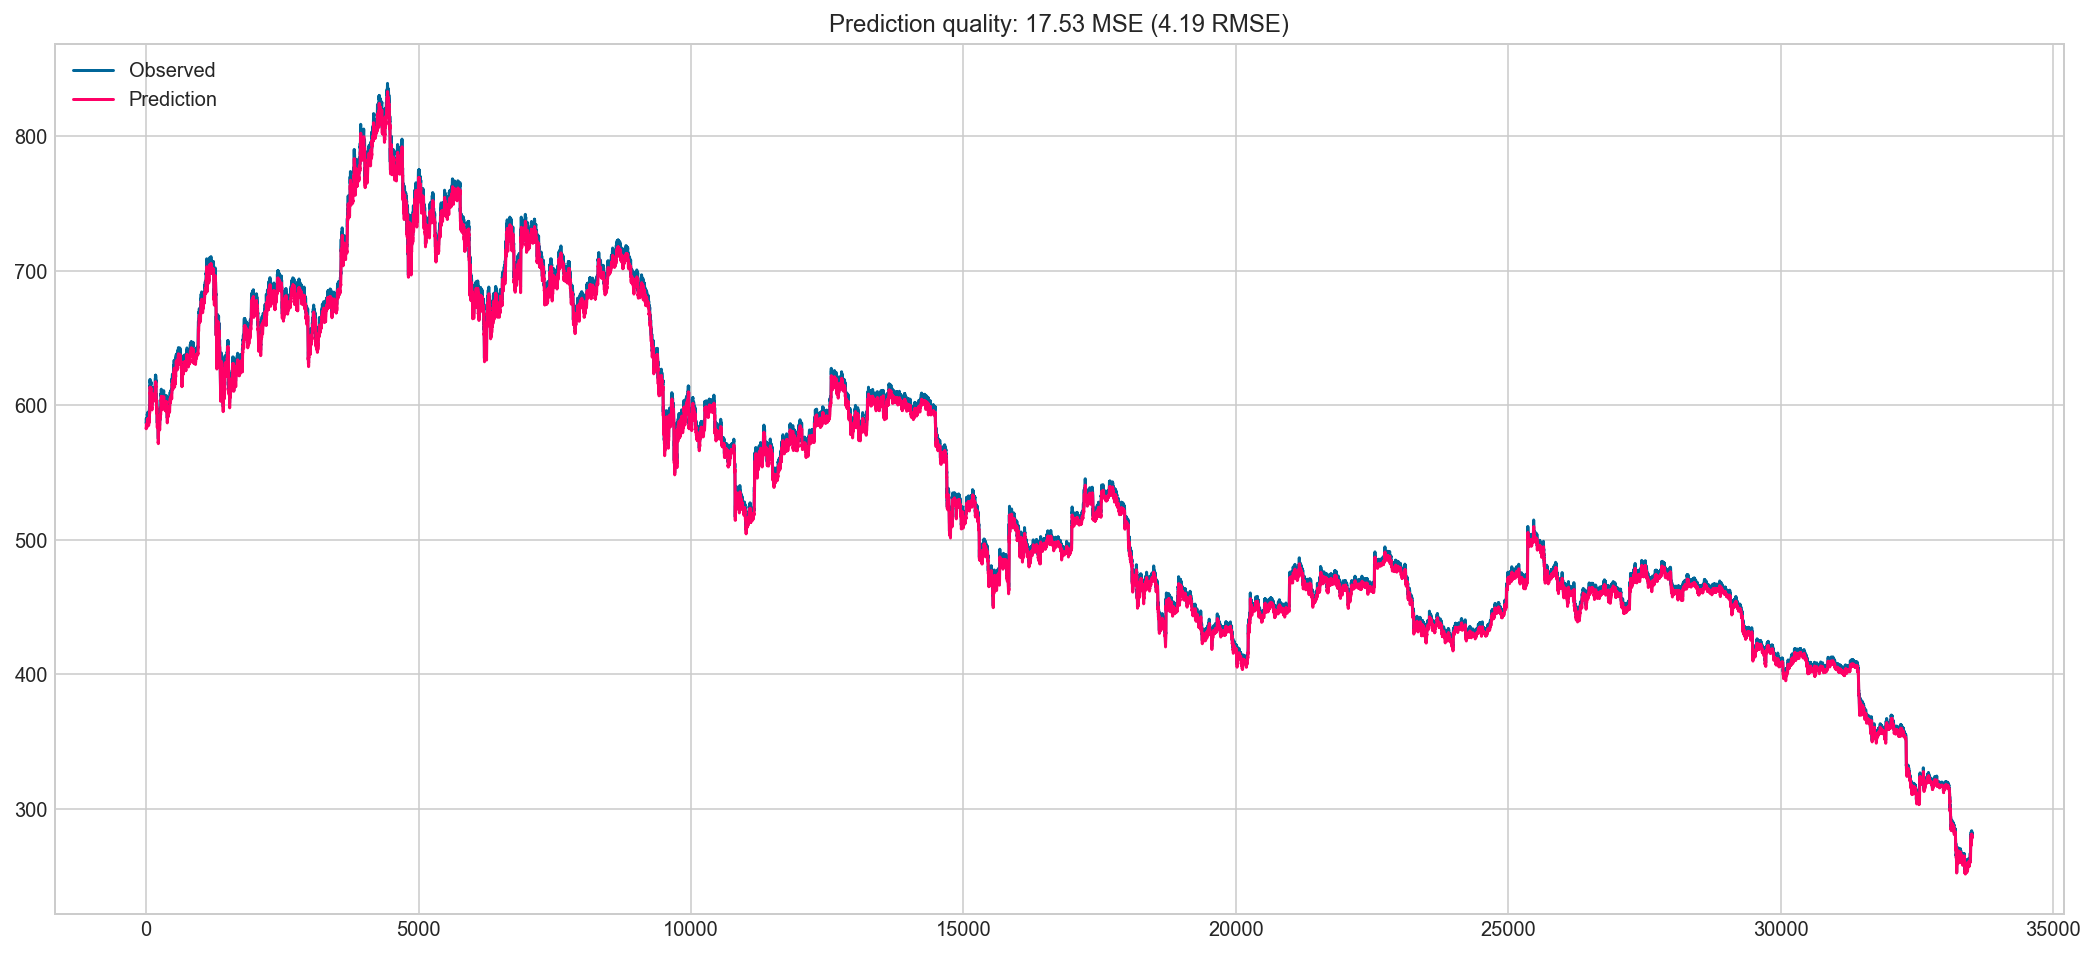

In [43]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.figure(figsize=(18, 8))
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');
plt.show()

It seems the prediction is pretty good. But really? Too good to be true..... 